In [23]:
# fix for windows memory leak with MKL
import os
import platform

if platform.system() == "Windows":
    os.environ["OMP_NUM_THREADS"] = "2"

# import libraries
import time
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # this is used for the plot of the graph

# Sklearn classes
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    KFold,
)
from sklearn import metrics
from sklearn.metrics import confusion_matrix, silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import tree
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from helper import (
    draw_confusion_matrix,
    heatmap,
    make_meshgrid,
    plot_contours,
    draw_contour,
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Sets random seed for reproducibility
SEED = 42
random.seed(SEED)

In [24]:
# Load Data
data = pd.read_csv("T8X531w18_wr3.csv")

# Handling Missing Values
data.fillna(data.mode().iloc[0], inplace=True)

# Pass or Fail
data['Bin'] = data['Bin'].apply(lambda x: 1 if x == 1 else 0)

In [25]:
# Identifying Features with High Correlation w/ Pass or Fail
corr_matrix = data.corr(numeric_only=True)
corr_matrix["Bin"].sort_values(ascending=False)

Bin                                                                      1.000000
a_clcXdelta_x_VBAT-3V6-IO-GND_tOFF-OFF__ivddio,300605,-                  0.937935
a_fcv_PMU_x_VBAT-2V3-100MS_tPMU-ANA-CTRL-VBAT-PLUG-WAKEUP__X,200749,0    0.495408
p_shortXend_PAD_x_500uA__NFC_GPIO2_AO,322,-                              0.485978
p_openXend_PAD_x_500uA__NFC_GPIO2_AO,122,-                               0.485978
                                                                           ...   
if_fcv_TOP-DLOG__W5-DATE,49014,TPDATA                                         NaN
if_fcv_TOP-DLOG__W4-HARDBIN,20041,-                                           NaN
if_fcv_TOP-DLOG__W4-SOFTBIN,20042,-                                           NaN
if_fcv_TOP-DLOG__W4-VERSION,49008,TPDATA                                      NaN
if_fcv_TOP-DLOG__W4-DATE,49013,TPDATA                                         NaN
Name: Bin, Length: 2870, dtype: float64

In [26]:
# Dropping Columns w/ NaN Correlation to Pass or Fail
nan_corr_columns = corr_matrix["Bin"][corr_matrix["Bin"].isna()].index
data.drop(columns=nan_corr_columns, inplace=True)

In [27]:
# Split Target and Data
y = data['Bin']
x = data.drop(['Bin'], axis=1)

# Train Test Split
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=0)

# Separating Into Numerical and Categorical Features
categorical_features = data.select_dtypes(exclude=["number"]).columns.tolist()
data_num = train_raw.drop(columns=categorical_features)
numerical_features = list(data_num)

# Applying Pipeline to Train and Test Data
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("normalizer", StandardScaler())])
full_pipeline = ColumnTransformer([("num", num_pipeline, numerical_features), ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)])

train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw)

In [28]:
# XGBoost

kf = KFold(n_splits=3, shuffle=True, random_state=42)

xgb_params = {
    "n_estimators": [100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=1)
xgb_grid.fit(train, target)
xgb_res = pd.DataFrame(xgb_grid.cv_results_)

relevant_columns = ['rank_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 
                    'mean_test_score', 'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']

top_3_xgb = xgb_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 XGBoost Models:")
print(top_3_xgb)
print("\nBest XGBoost Parameters:", xgb_grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:38:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Top 3 XGBoost Models:
   rank_test_score  param_n_estimators  param_max_depth  param_learning_rate  \
0                1                 100                3                 0.05   
1                1                 100                3                 0.05   
2                1                 100                5                 0.05   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0         0.997412        0.001595      36.962339      2.810131   
1         0.997412        0.001595      34.858892      2.392774   
2         0.997412        0.001595      39.025126      5.425861   

   mean_score_time  std_score_time  
0         0.068396        0.035473  
1         0.051815        0.023617  
2         0.062575        0.006726  

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [29]:
# LightGBM

lgbm_params = {
    "n_estimators": [100, 200],
    "max_depth": [-1],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [50, 100] 
}

lgbm = LGBMClassifier(random_state=42)
lgbm_grid = GridSearchCV(lgbm, lgbm_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=1)
lgbm_grid.fit(train, target)
lgbm_res = pd.DataFrame(lgbm_grid.cv_results_)

relevant_columns = ['rank_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_num_leaves', 'mean_test_score', 
                    'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']

top_3_lgbm = lgbm_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 LightGBM Models:")
print(top_3_lgbm)
print("\nBest LightGBM Parameters:", lgbm_grid.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 3360, number of negative: 504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186574
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 1547
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.869565 -> initscore=1.897120
[LightGBM] [Info] Start training from score 1.897120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [30]:
# Random Forest

rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [16, 32],
    "min_samples_split": [2, 4],
    "criterion": ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=1)
rf_grid.fit(train, target)
rf_res = pd.DataFrame(rf_grid.cv_results_)

relevant_columns = ['rank_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_test_score', 
                    'std_test_score', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']

top_3_rf = rf_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 Random Forest Models:")
print(top_3_rf)
print("\nBest Random Forest Parameters:", rf_grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Top 3 Random Forest Models:
   rank_test_score  param_n_estimators  param_max_depth  \
0                1                 100               16   
1                1                 200               16   
2                1                 100               16   

   param_min_samples_split param_criterion  mean_test_score  std_test_score  \
0                        2            gini         0.997412        0.001595   
1                        2            gini         0.997412        0.001595   
2                        4            gini         0.997412        0.001595   

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  
0       4.355254      0.352148         1.130427        0.063517  
1       8.337151      0.604668         2.124981        0.041986  
2       4.381115      0.426309         1.072157        0.055375  

Best Random Forest Parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 

In [31]:
# SVM

svm_params = {
    'C': [1, 10],
    'gamma': ['scale'],
    'kernel': ['rbf', 'linear']
}

svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, svm_params, cv=kf, scoring="accuracy", n_jobs=-1, verbose=1)
svm_grid.fit(train, target)
svm_res = pd.DataFrame(svm_grid.cv_results_)

relevant_columns = ['rank_test_score', 'param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score'
                    , 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']

top_3_svm = svm_res[relevant_columns].sort_values(by='rank_test_score').head(3)
print("\nTop 3 SVM Models:")
print(top_3_svm)
print("\nBest SVM Parameters:", svm_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Top 3 SVM Models:
   rank_test_score  param_C param_gamma param_kernel  mean_test_score  \
0                1        1       scale          rbf         0.999741   
1                1        1       scale       linear         0.999741   
2                1       10       scale          rbf         0.999741   

   std_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0        0.000366      12.962696      0.582635         5.520997   
1        0.000366       6.998234      0.070864         2.119063   
2        0.000366      11.062802      0.706936         4.131108   

   std_score_time  
0        0.209046  
1        0.053762  
2        1.795366  

Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [34]:
# Extract top model from each GridSearch result
top_xgb_model = xgb_res.sort_values(by='rank_test_score').head(1)
top_lgbm_model = lgbm_res.sort_values(by='rank_test_score').head(1)
top_rf_model = rf_res.sort_values(by='rank_test_score').head(1)
top_svm_model = svm_res.sort_values(by='rank_test_score').head(1)

# Select relevant columns including timing metrics
xgb_summary = top_xgb_model[['mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].copy()
xgb_summary['Model'] = 'XGBoost'

lgbm_summary = top_lgbm_model[['mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_num_leaves', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].copy()
lgbm_summary['Model'] = 'LightGBM'

rf_summary = top_rf_model[['mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_criterion', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].copy()
rf_summary['Model'] = 'Random Forest'

svm_summary = top_svm_model[['mean_test_score', 'param_C', 'param_gamma', 'param_kernel', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']].copy()
svm_summary['Model'] = 'SVM'

# Normalize column names for merging
xgb_summary.columns = ['Accuracy', 'n_estimators', 'max_depth', 'learning_rate', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'Model']
lgbm_summary.columns = ['Accuracy', 'n_estimators', 'max_depth', 'learning_rate', 'num_leaves', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'Model']
rf_summary.columns = ['Accuracy', 'n_estimators', 'max_depth', 'min_samples_split', 'criterion', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'Model']
svm_summary.columns = ['Accuracy', 'C', 'gamma', 'kernel', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'Model']

# Combine all into one table
summary_table = pd.concat([svm_summary, lgbm_summary, xgb_summary, rf_summary], ignore_index=True)

# Display the summary table
print("\nTop Performing Models Summary with Timing Info:")
print(summary_table)



Top Performing Models Summary with Timing Info:
   Accuracy    C  gamma kernel  mean_fit_time  std_fit_time  mean_score_time  \
0  0.999741  1.0  scale    rbf      12.962696      0.582635         5.520997   
1  0.997671  NaN    NaN    NaN      48.810785      5.831951         0.068428   
2  0.997412  NaN    NaN    NaN      36.962339      2.810131         0.068396   
3  0.997412  NaN    NaN    NaN       4.355254      0.352148         1.130427   

   std_score_time          Model  n_estimators  max_depth  learning_rate  \
0        0.209046            SVM           NaN        NaN            NaN   
1        0.004790       LightGBM         100.0       -1.0           0.05   
2        0.035473        XGBoost         100.0        3.0           0.05   
3        0.063517  Random Forest         100.0       16.0            NaN   

   num_leaves  min_samples_split criterion  
0         NaN                NaN       NaN  
1        50.0                NaN       NaN  
2         NaN                NaN  

Baseline Test Accuracy:   0.998792
Training Time:            1.4634 seconds
Prediction Time:          0.0177 seconds


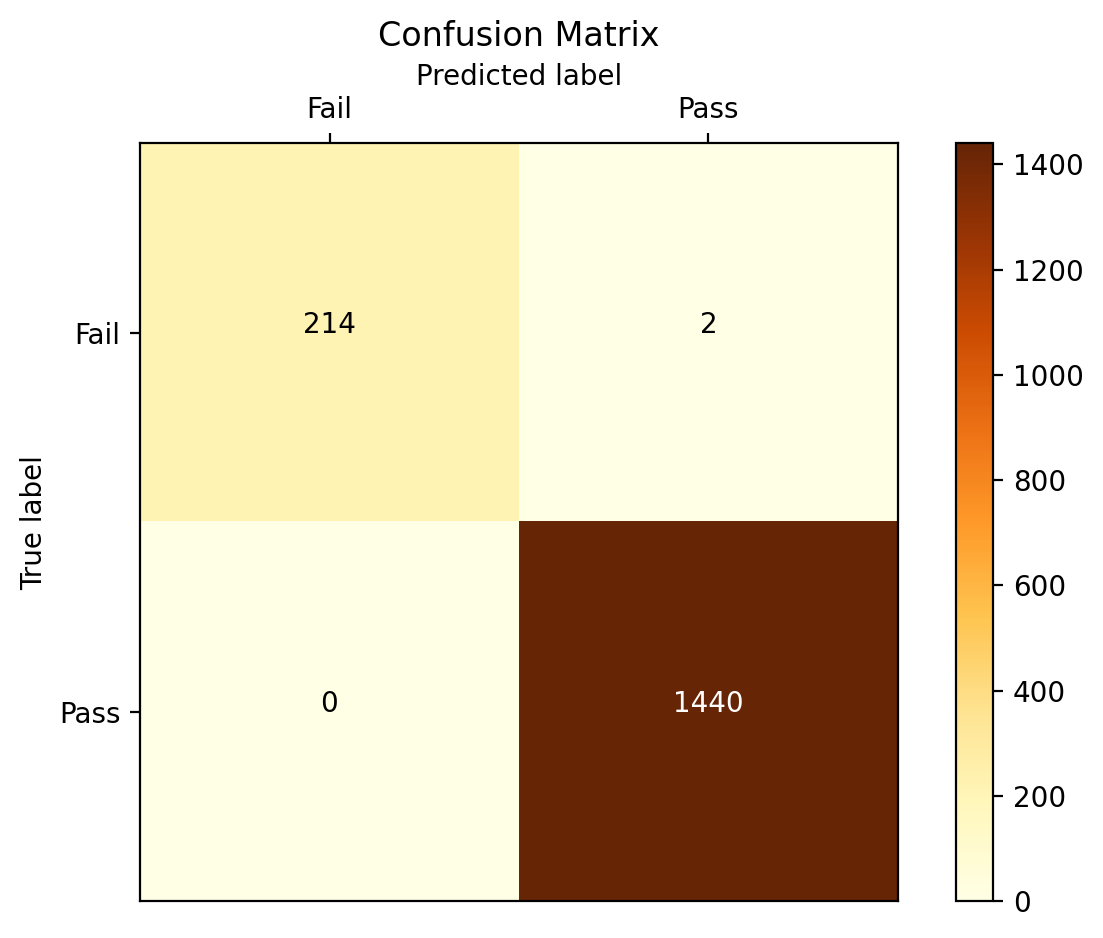

In [37]:
# Baseline Model Used in Groot

# Start timing the training
start_fit = time.time()
dt = DecisionTreeClassifier(random_state=42, criterion='entropy')
dt.fit(train, target)
end_fit = time.time()

# Start timing the prediction
start_pred = time.time()
predicted = dt.predict(test)
end_pred = time.time()

# Calculate accuracy and timing
accuracy = metrics.accuracy_score(target_test, predicted)
fit_time = end_fit - start_fit
score_time = end_pred - start_pred

# Display results
print("%-25s %f" % ('Baseline Test Accuracy:', accuracy))
print("%-25s %.4f seconds" % ('Training Time:', fit_time))
print("%-25s %.4f seconds" % ('Prediction Time:', score_time))
draw_confusion_matrix(target_test, predicted, ['Fail', 'Pass'])

Test Accuracy: 0.998188


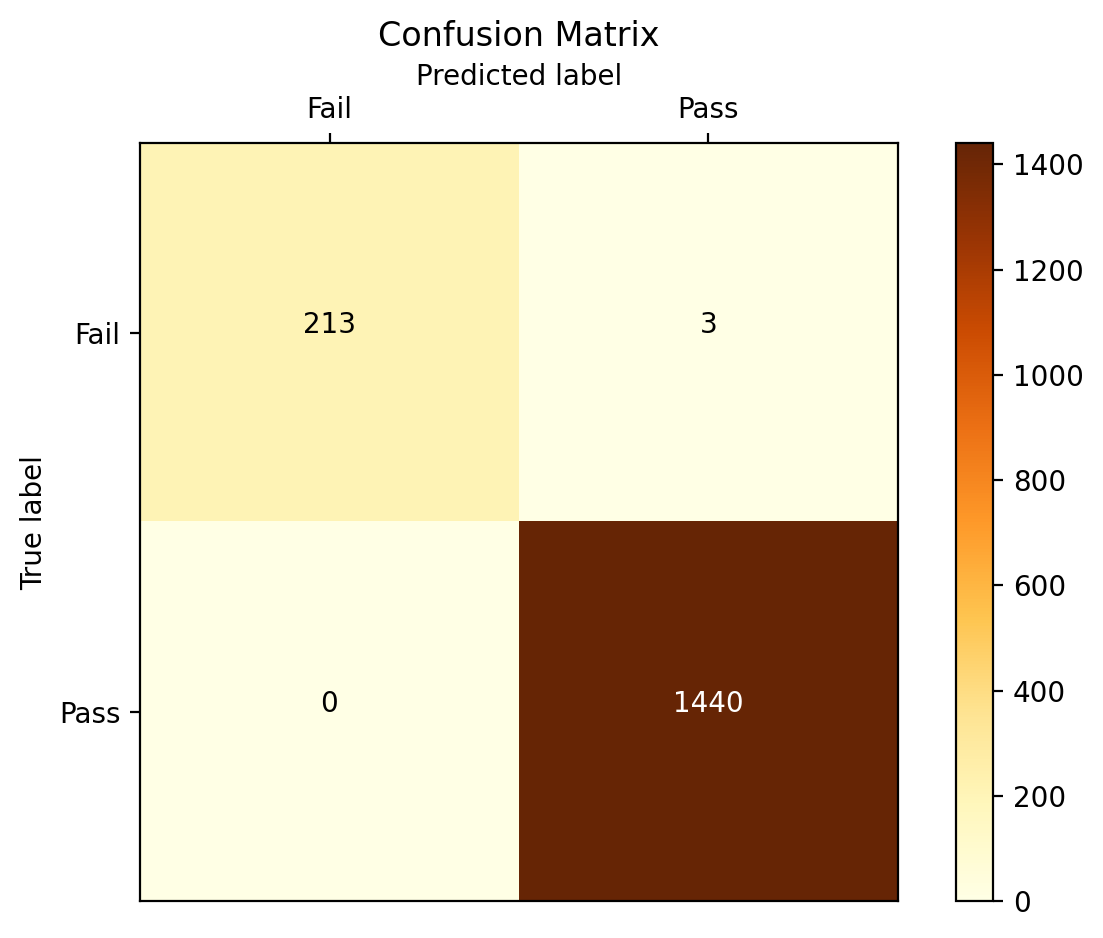

In [38]:
xgb = XGBClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8)
xgb.fit(train, target)
predicted = xgb.predict(test)
print("%-12s %f" % ('Test Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Fail', 'Pass'])

[LightGBM] [Info] Number of positive: 3360, number of negative: 504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186574
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 1547
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.869565 -> initscore=1.897120
[LightGBM] [Info] Start training from score 1.897120
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

c:\Users\nxg15046\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test Accuracy: 0.998188


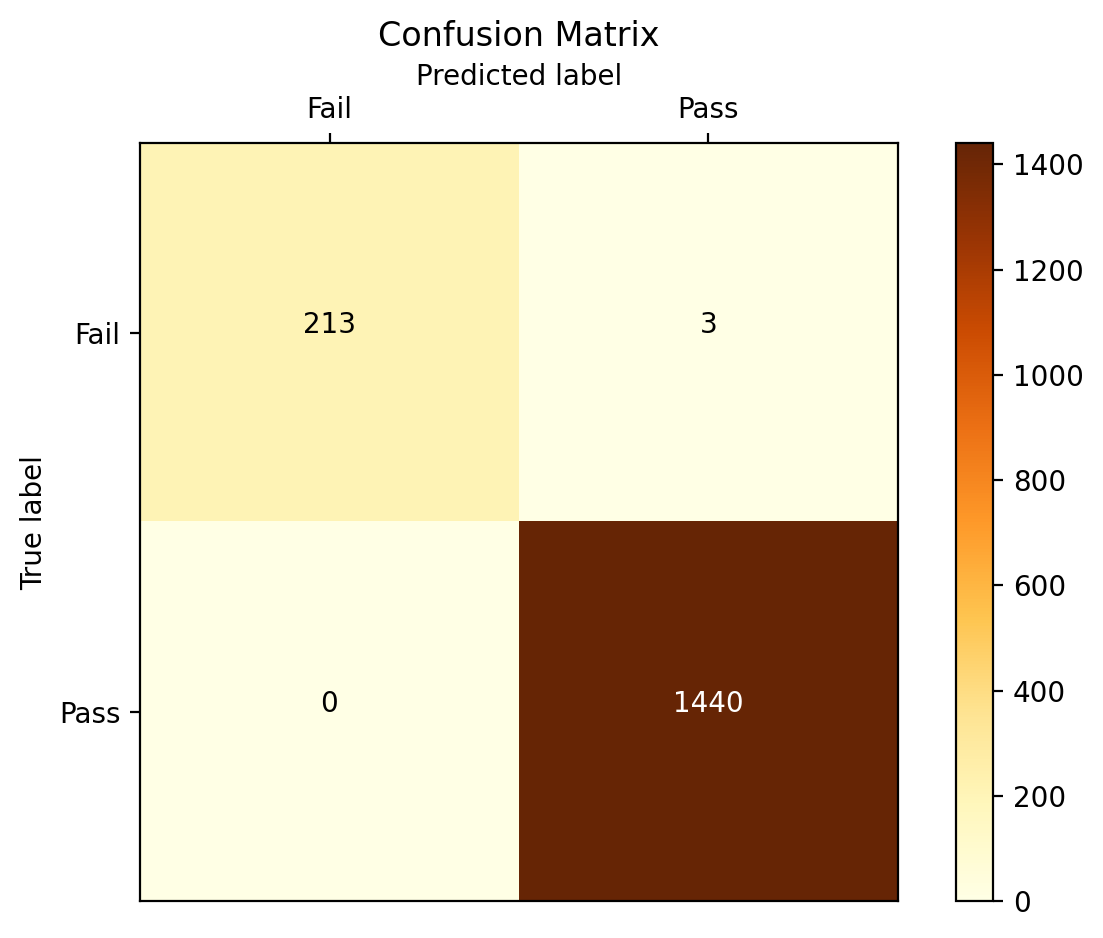

In [39]:
lgbm = LGBMClassifier(learning_rate=0.05, max_depth=-1, n_estimators=100, num_leaves=50)
lgbm.fit(train, target)
predicted = lgbm.predict(test)
print("%-12s %f" % ('Test Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Fail', 'Pass'])

Test Accuracy: 0.998188


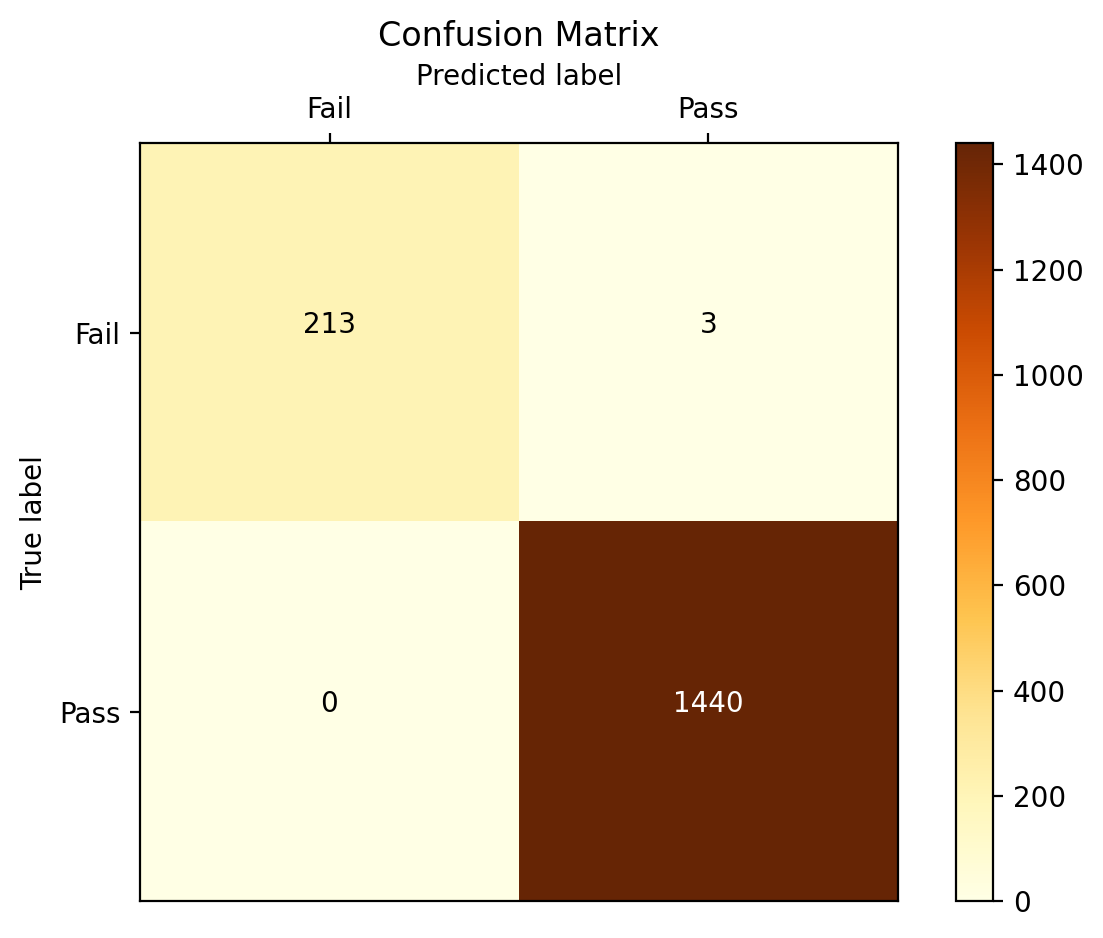

In [40]:
rf = RandomForestClassifier(criterion='gini', max_depth=16, min_samples_split=2, n_estimators=100)
rf.fit(train, target)
predicted = rf.predict(test)
print("%-12s %f" % ('Test Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Fail', 'Pass'])

Test Accuracy: 1.000000


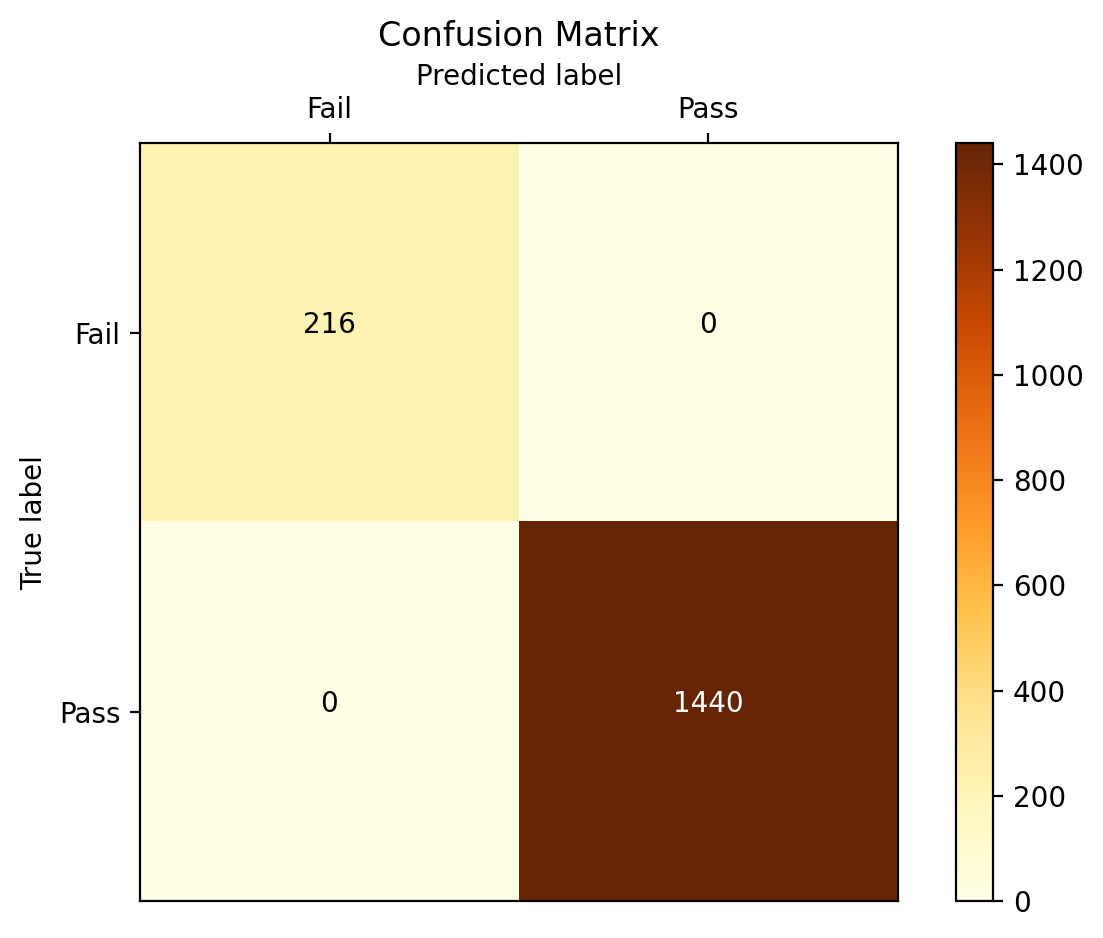

In [41]:
svm = SVC(C=1, gamma='scale', kernel='rbf')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Test Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['Fail', 'Pass'])